In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm
import pandas as pd
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Read Data Set

In [2]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [3]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [4]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [5]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

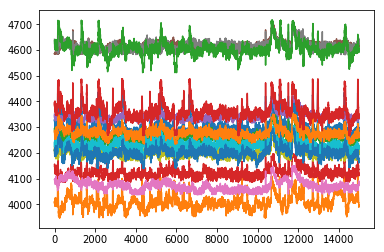

In [6]:
_ = plt.plot(df)

Standardize using a z-score: 

$$z_{i,d} = \frac{x_{i,d} - \mu_d}{\sigma_d}$$

+ $\mu_d$ : mean along dimension $d$
+ $\sigma_d$ : std along dimension $d$
+ $x_{i,d}$ : $i$-th coordinate along dimension $d$

In [7]:
df = (df - df.mean()) * 1./(df.std()+0.00001)

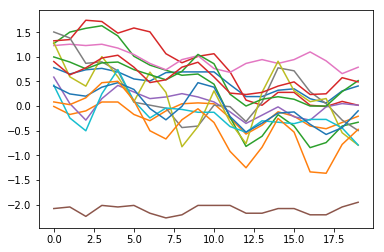

In [8]:
_ = plt.plot(df.values[:20,:])

array([ 0.57283201,  0.7255303 ,  0.83945576,  0.87465887,  0.90188819,
        0.92376058,  0.93942966,  0.95297484,  0.96519949,  0.97588912,
        0.98430863,  0.9919202 ,  0.99777014,  1.        ])

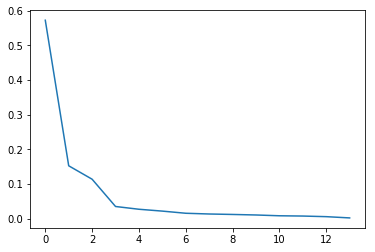

In [14]:
from sklearn import decomposition
pca = decomposition.PCA(df.shape[1])
pca.fit(df)
X_pc = pca.transform(df)
#plt.plot(X_pc)
plt.plot(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

# Variational Auto Encoder LSTM

## Sampling

In [15]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

## Loss

In [16]:
def vae_loss(x, x_decoded_mean_squash):
    #x = K.flatten(x)
    #x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = 10*K.mean(metrics.binary_crossentropy(x, x_decoded_mean_squash))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

# Encoder

### Meta Parameters

In [17]:
input_dim = df.shape[1]
timesteps = 20
jump = 5
nb_epoch = 30

validation_split = 0.1
batch_size = 32

lstm_1_size = 30
lstm_2_size = 15
intermediate_dim = 7
latent_dim = 2

epsilon_std = 0.01

## Generate the time series

In [18]:
indexes = [range(i,i+timesteps) for i in range(0,df.shape[0]-jump-timesteps,jump)]
X = df.values[indexes]

## Encoder

In [19]:
inputs = Input(shape=(timesteps, input_dim))
encoded_h1 = LSTM(lstm_1_size,return_sequences=True)(inputs)
encoded_h2 = LSTM(lstm_2_size)(encoded_h1)
encoded_hidden = Dense(intermediate_dim, activation='tanh')(encoded_h2)

z_mean = Dense(latent_dim)(encoded_hidden)
z_log_sigma = Dense(latent_dim)(encoded_hidden)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [20]:
sequence_encoder = Model(inputs=inputs, outputs=z_mean)
sequence_encoder.compile(optimizer='rmsprop', loss=vae_loss)

## Decoder

In [21]:
_decoded_hidden = Dense(intermediate_dim, activation='tanh')
_decoded_repeated = RepeatVector(timesteps)
_decoded_h2 = LSTM(lstm_2_size,return_sequences=True)
_decoded_h1 = LSTM(lstm_1_size,return_sequences=True)
_decoded = LSTM(input_dim,return_sequences=True)

In [22]:
decoded_inputs = Input(shape = (latent_dim,))
decoded_hidden = _decoded_hidden(decoded_inputs)
decoded_repeated = _decoded_repeated(decoded_hidden)
decoded_h2 = _decoded_h2(decoded_repeated)
decoded_h1 = _decoded_h1(decoded_h2)
decoded =  _decoded(decoded_h1)

In [23]:
sequence_decoder = Model(decoded_inputs, decoded)
sequence_decoder.compile(optimizer='rmsprop', loss=vae_loss)

## Auto Encoder

In [24]:
ae_decoded_hidden = _decoded_hidden(z)
ae_decoded_repeated = _decoded_repeated(ae_decoded_hidden)
ae_decoded_h2 = _decoded_h2(ae_decoded_repeated)
ae_decoded_h1 = _decoded_h1(ae_decoded_h2)
ae_decoded =  _decoded(ae_decoded_h1)

In [25]:
sequence_autoencoder = Model(inputs, ae_decoded)
sequence_autoencoder.compile(optimizer='rmsprop', loss=vae_loss)

# Fit 

In [26]:
filepath_loss = "checkpoint/better_loss_.hdf5"
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='auto')
filepath_val_loss = "checkpoint/better_val_loss_epoch-{epoch:02d}.hdf5"   
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      mode='auto')
callbacks_list = [checkpoint_loss,
                  checkpoint_val_loss]
history = sequence_autoencoder.fit(X,
                                   X,
                                   batch_size,
                                   nb_epoch,
                                   callbacks = callbacks_list,
                                   validation_split=validation_split,
                                   verbose = 1,
                                   shuffle = True)

Train on 2691 samples, validate on 300 samples
Epoch 1/30
2691/2691 [==============================] - 16s - loss: -13.1261 - val_loss: -39.2194
Epoch 2/30
2691/2691 [==============================] - 13s - loss: -28.1911 - val_loss: -44.7278
Epoch 3/30
2691/2691 [==============================] - 13s - loss: -33.6411 - val_loss: -45.0964
Epoch 4/30
2691/2691 [==============================] - 14s - loss: -39.0591 - val_loss: -46.2609
Epoch 5/30
2691/2691 [==============================] - 14s - loss: -41.6995 - val_loss: -49.8365
Epoch 6/30
2691/2691 [==============================] - 14s - loss: -43.5893 - val_loss: -51.3946
Epoch 7/30
2691/2691 [==============================] - 14s - loss: -46.7352 - val_loss: -53.3143
Epoch 8/30
2691/2691 [==============================] - 14s - loss: -48.5250 - val_loss: -53.9987
Epoch 9/30
2691/2691 [==============================] - 14s - loss: -49.2568 - val_loss: -55.2057
Epoch 10/30
2691/2691 [==============================] - 14s - loss: -4

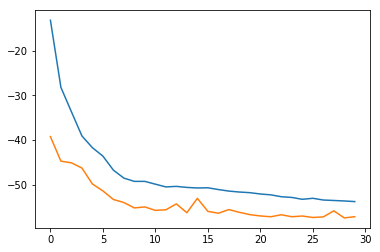

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Predict

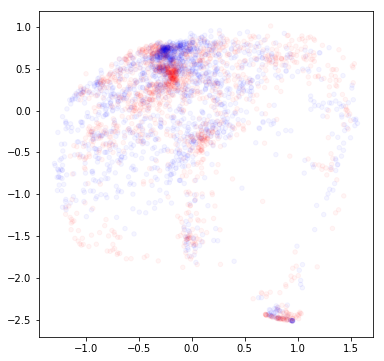

In [38]:
x_test_encoded = sequence_encoder.predict(X, batch_size=batch_size)
colors_map = {1:"red", 0:"blue"}
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=map(colors_map.__getitem__,y), alpha = 0.04,s = 20)
#plt.colorbar()
plt.show()

# Generate

/Library/Python/2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


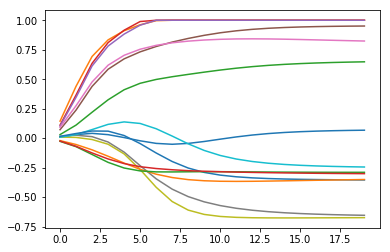

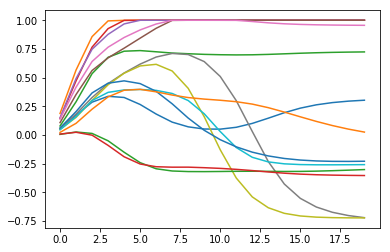

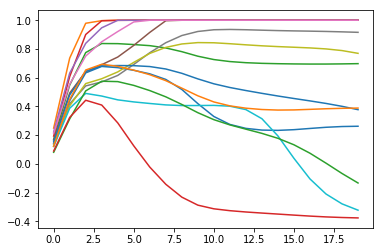

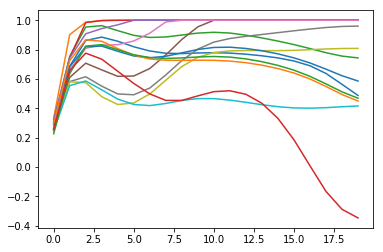

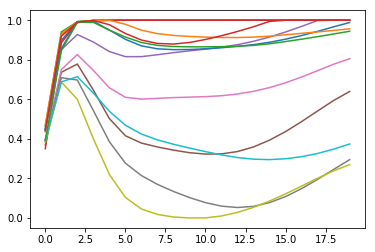

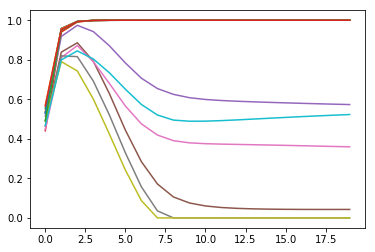

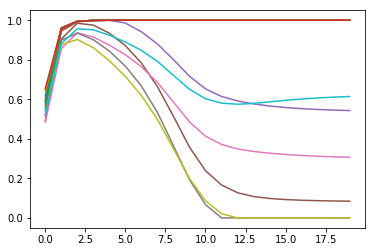

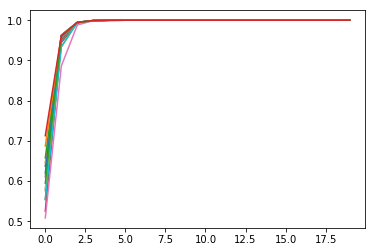

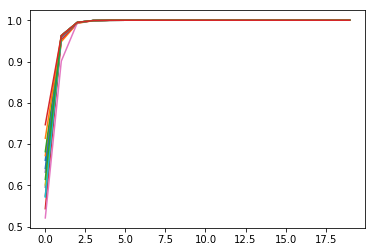

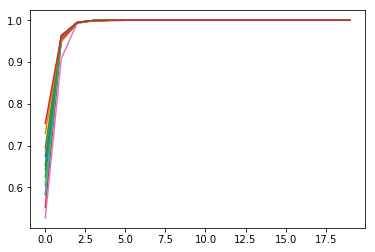

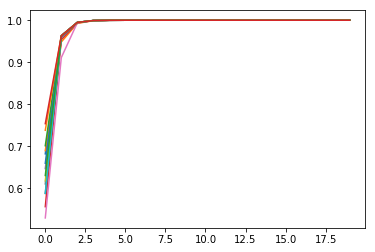

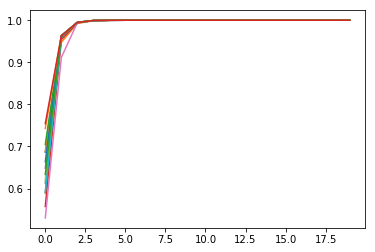

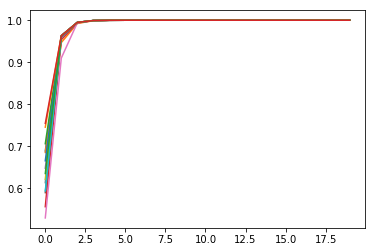

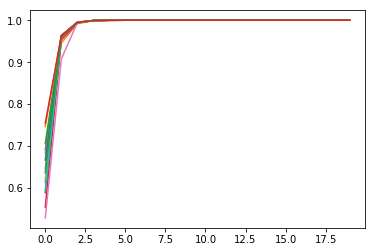

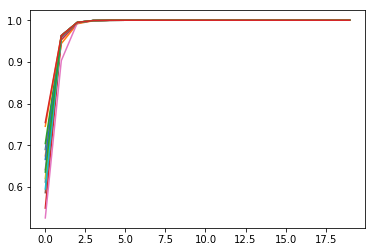

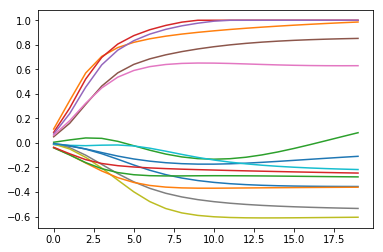

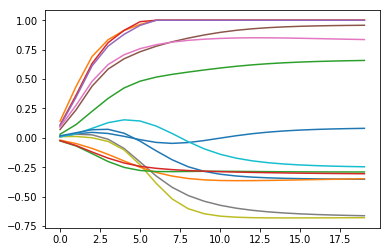

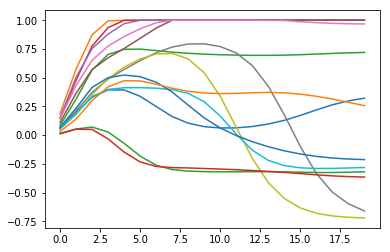

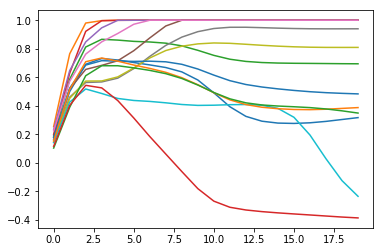

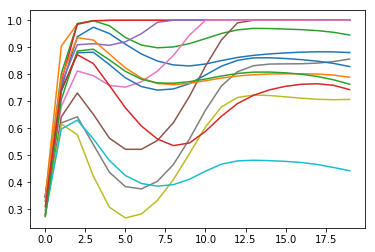

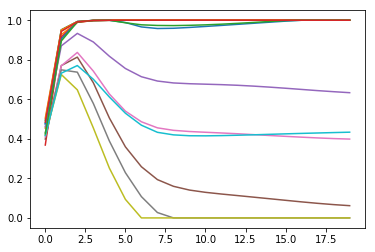

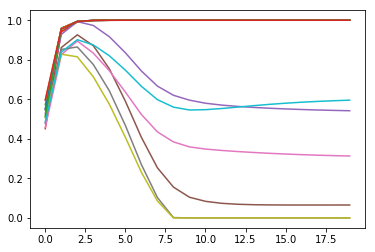

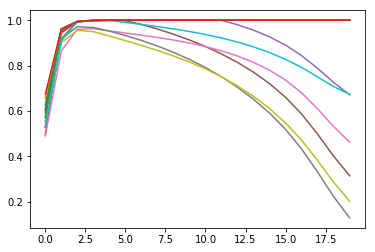

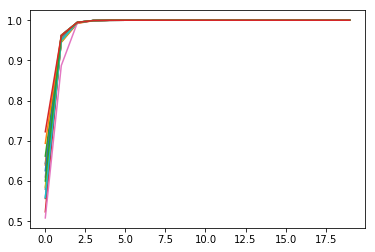

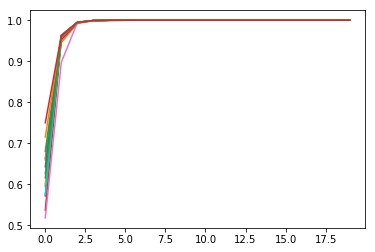

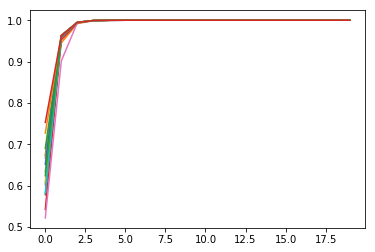

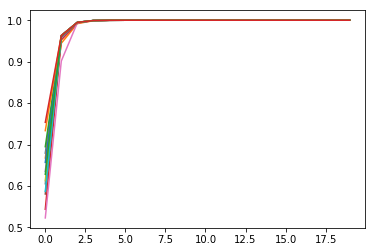

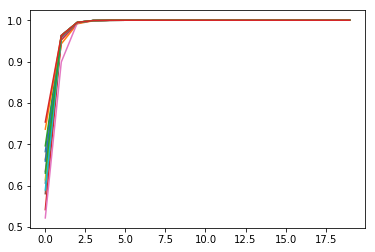

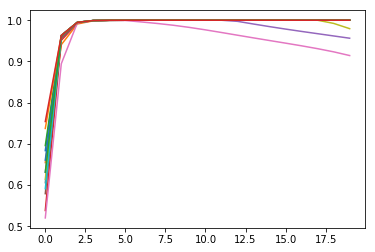

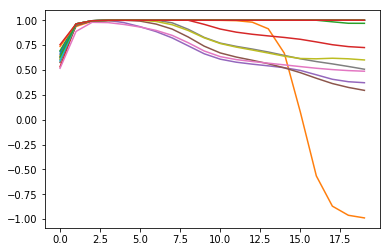

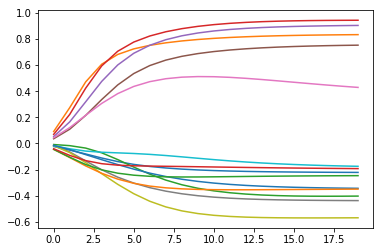

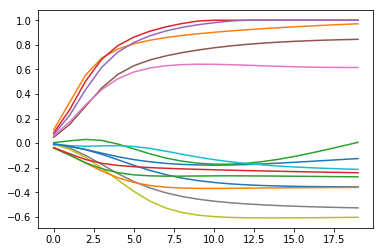

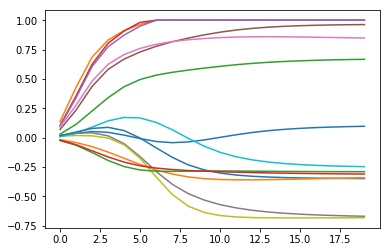

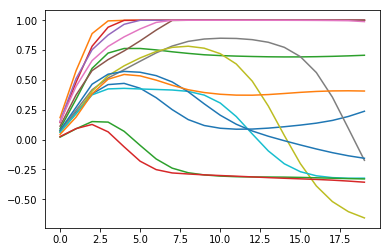

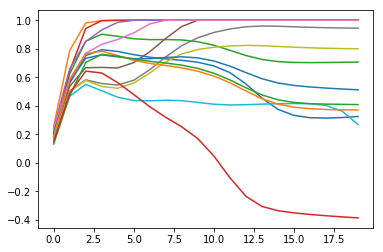

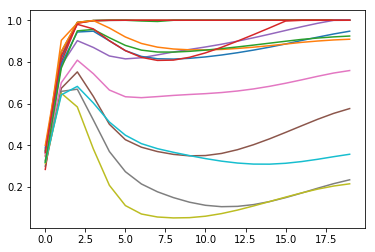

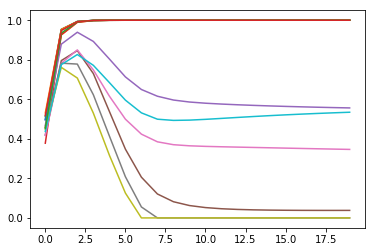

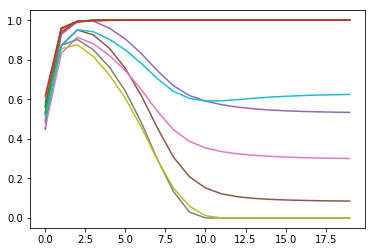

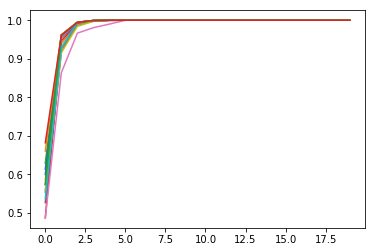

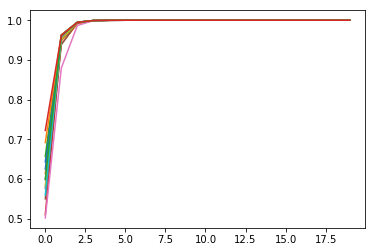

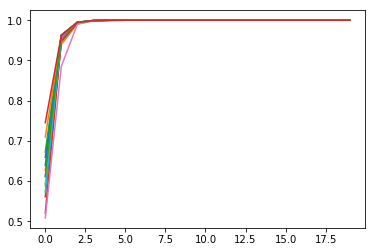

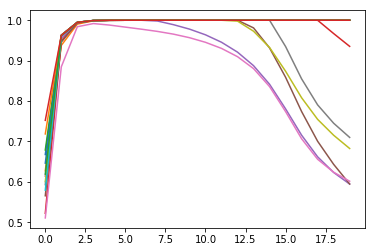

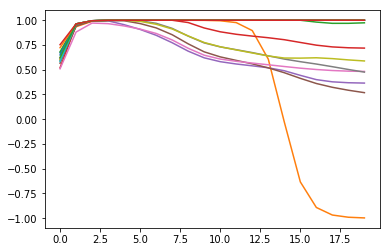

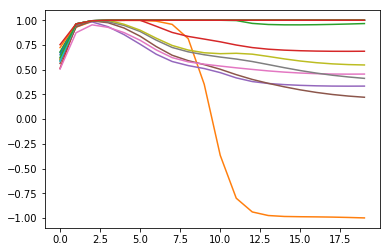

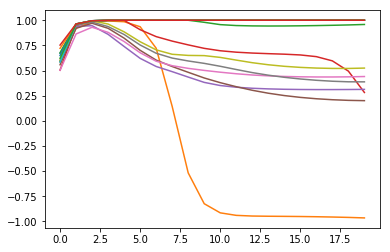

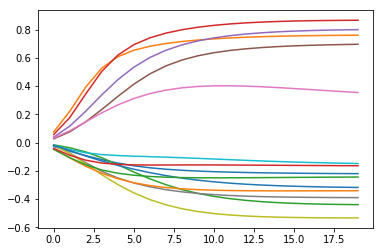

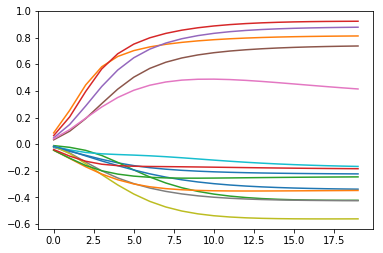

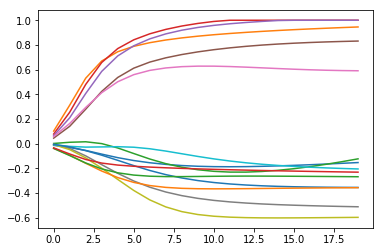

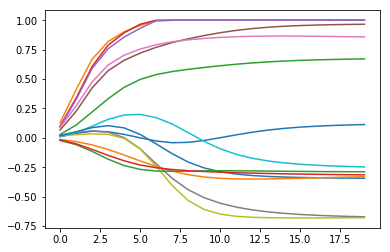

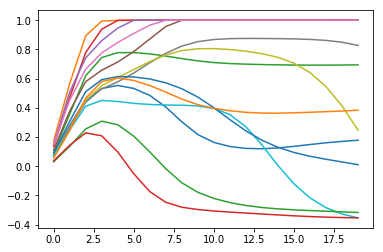

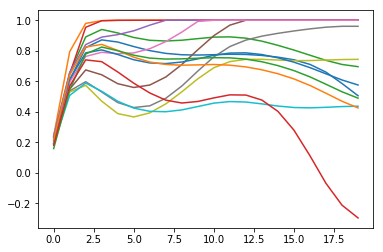

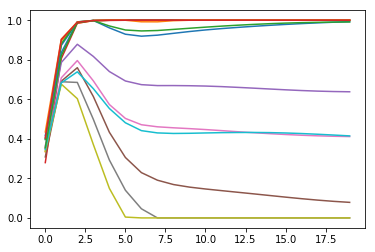

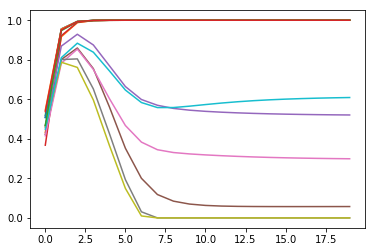

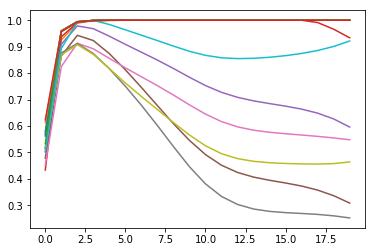

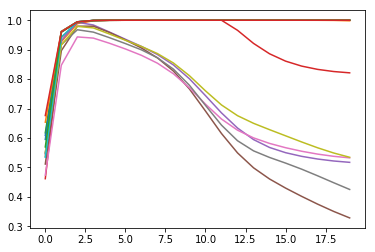

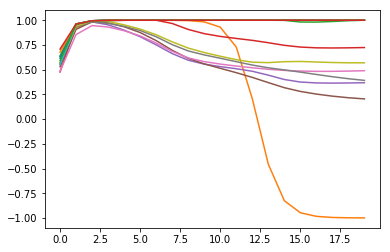

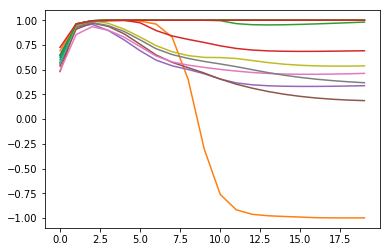

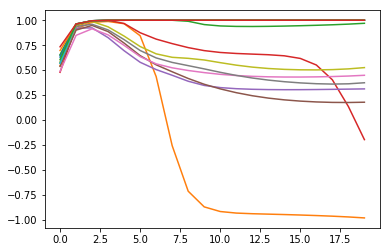

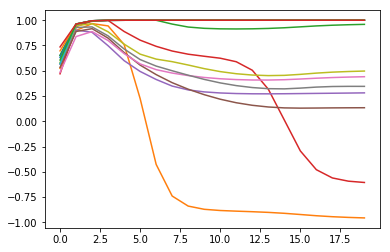

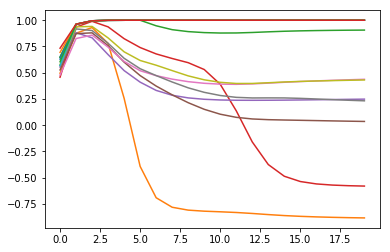

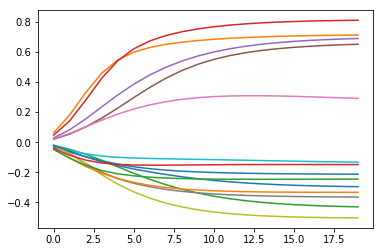

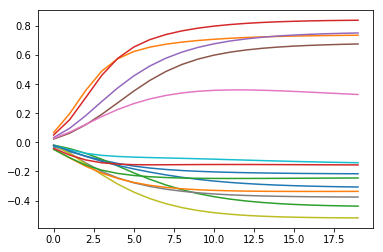

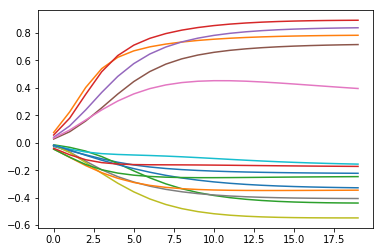

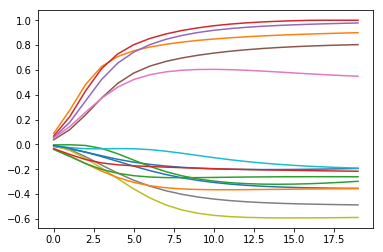

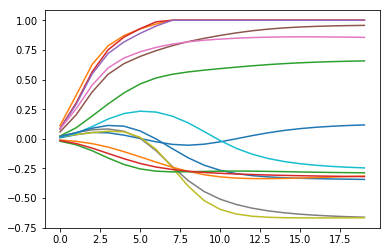

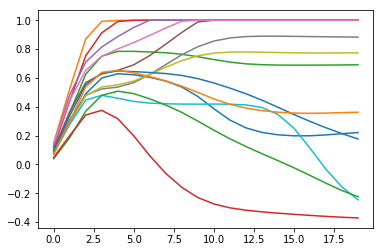

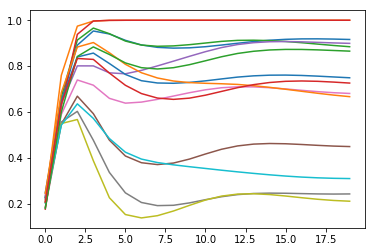

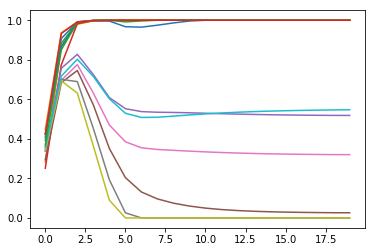

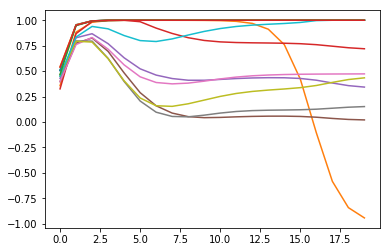

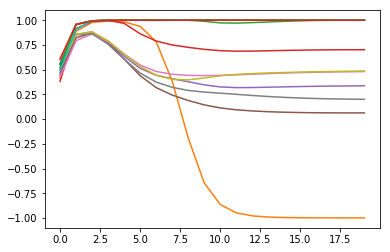

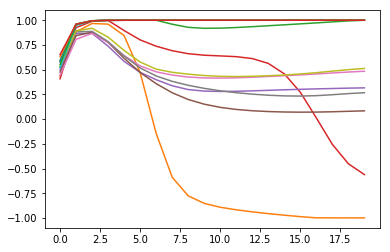

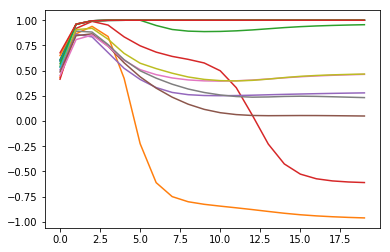

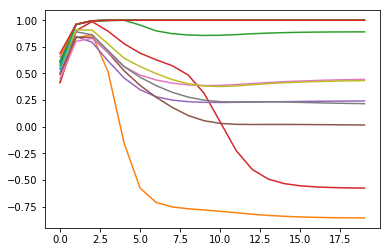

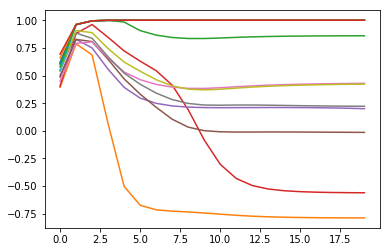

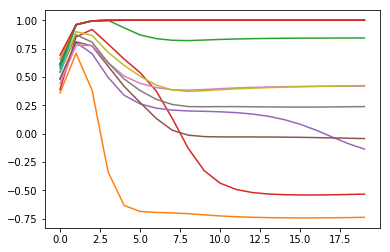

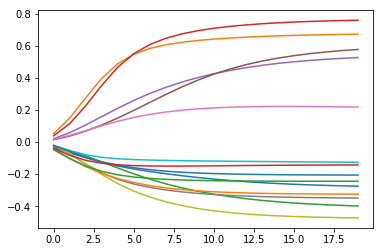

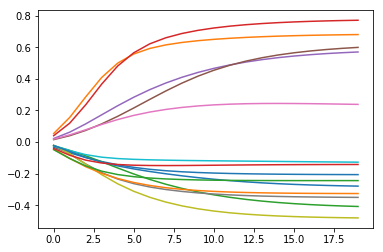

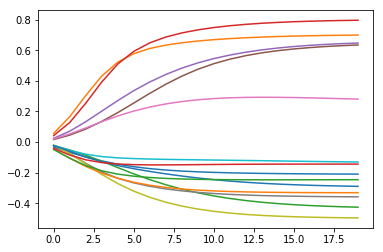

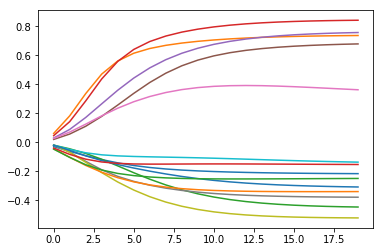

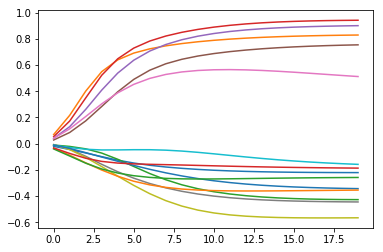

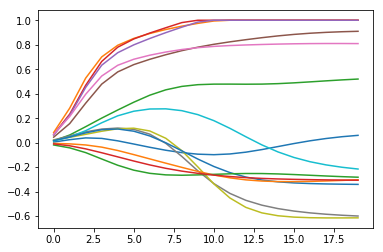

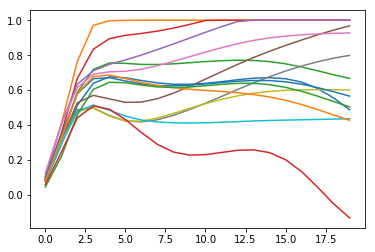

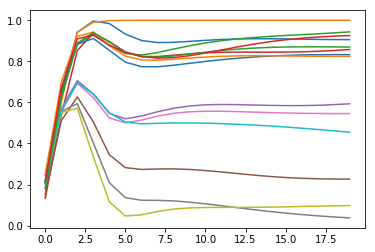

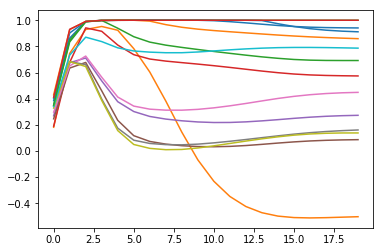

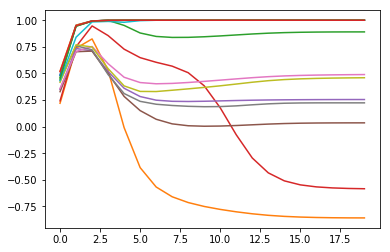

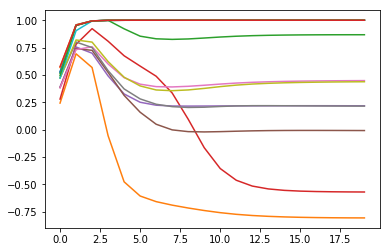

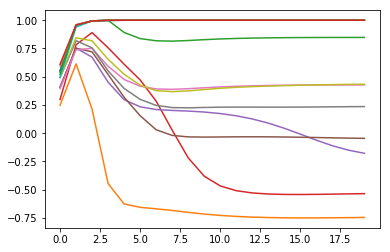

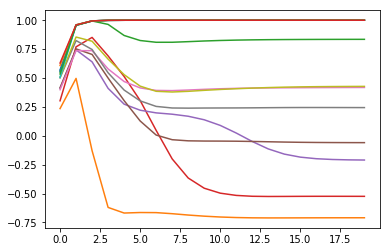

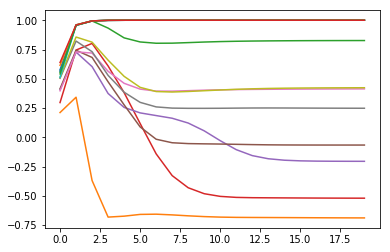

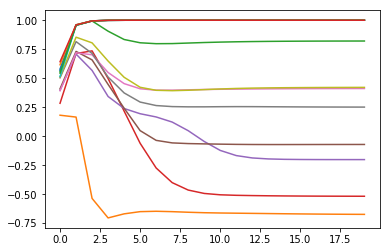

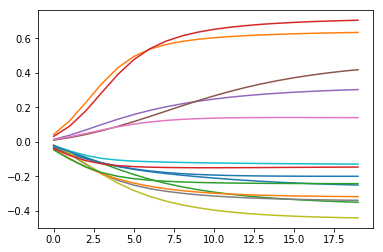

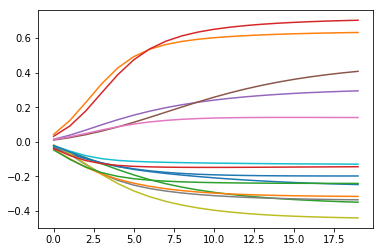

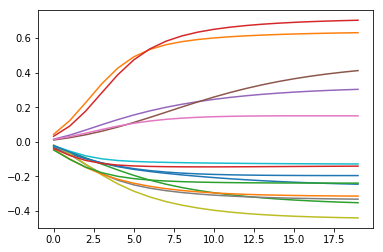

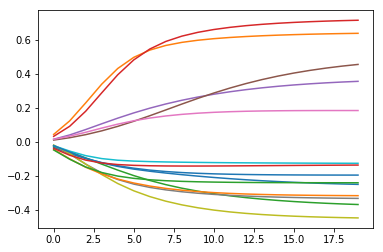

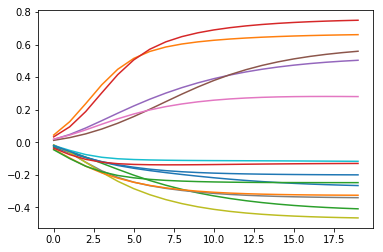

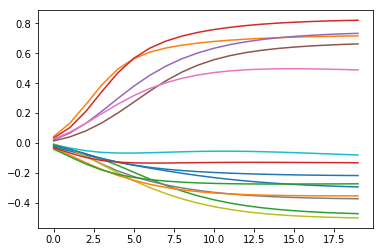

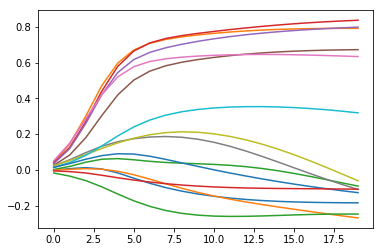

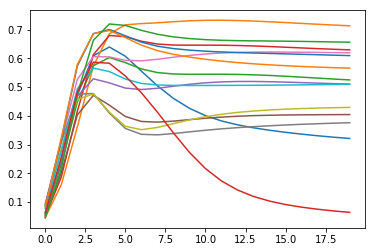

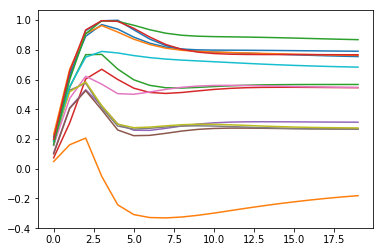

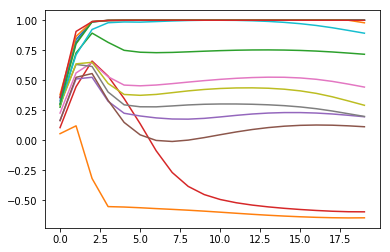

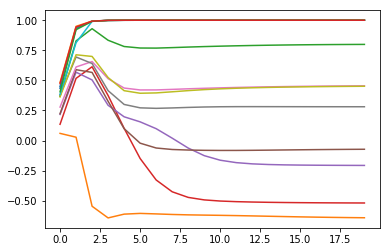

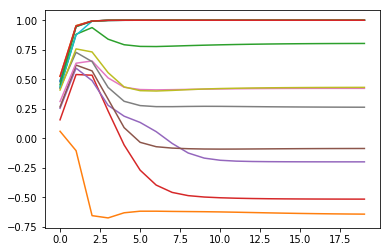

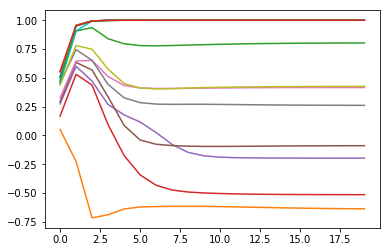

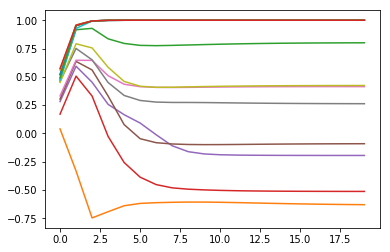

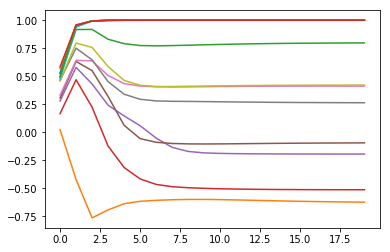

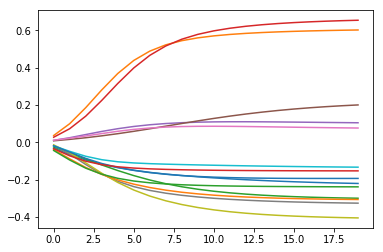

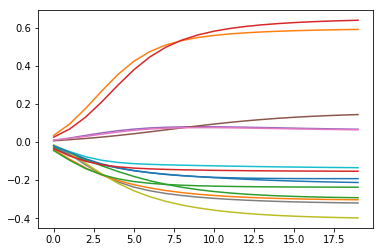

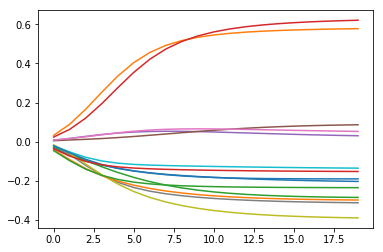

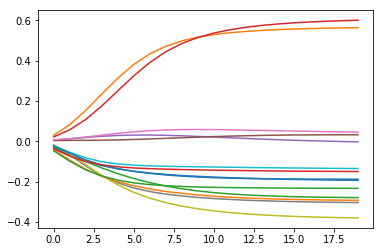

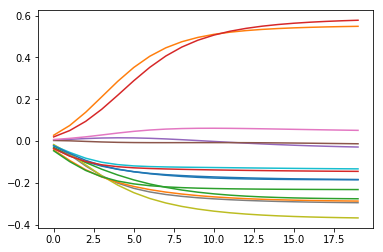

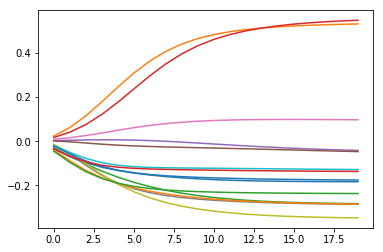

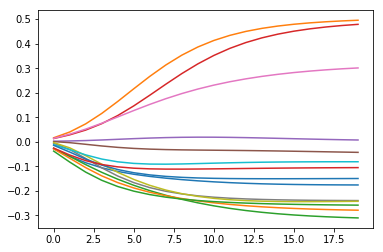

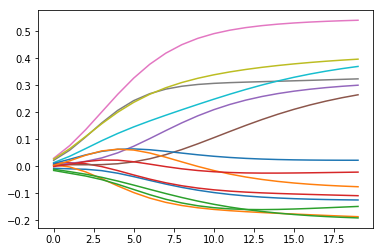

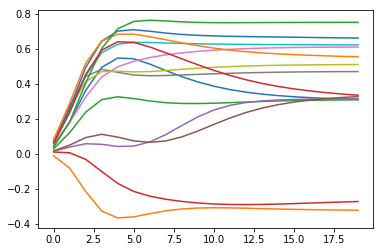

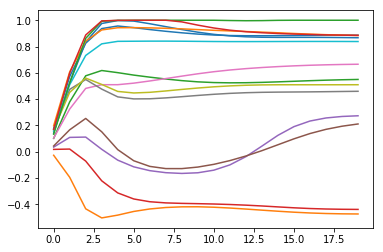

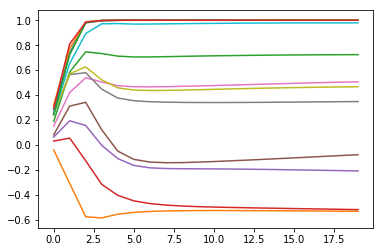

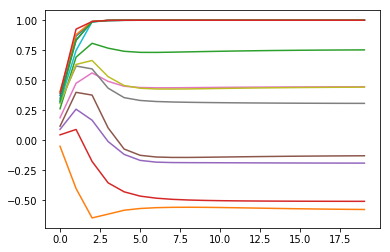

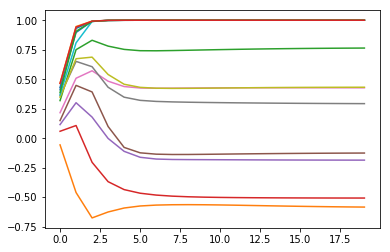

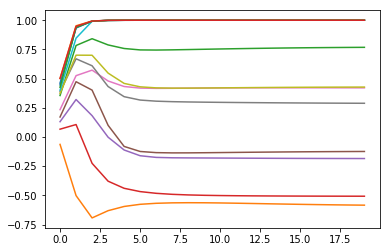

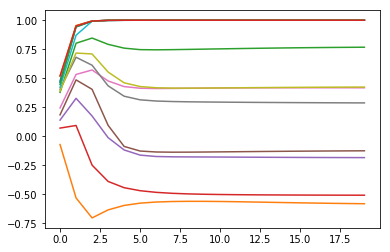

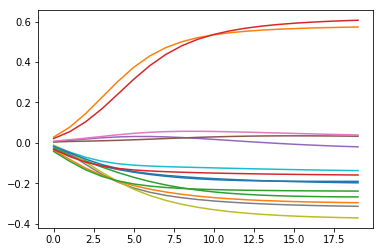

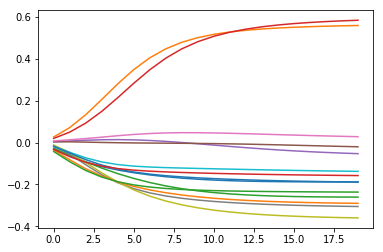

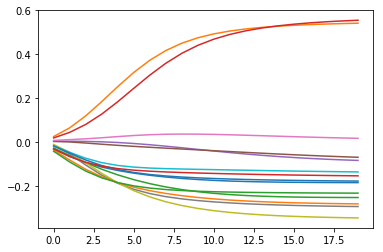

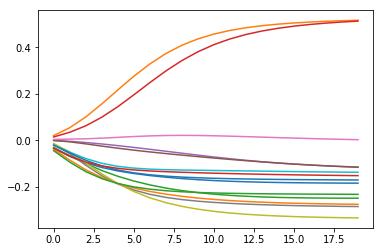

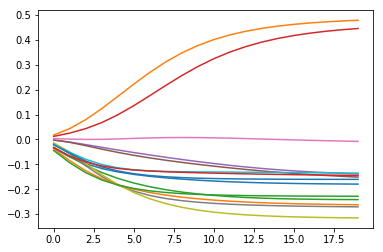

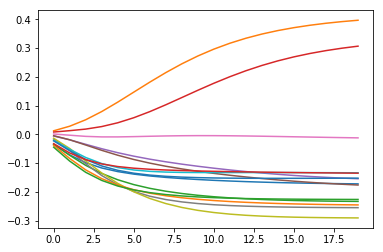

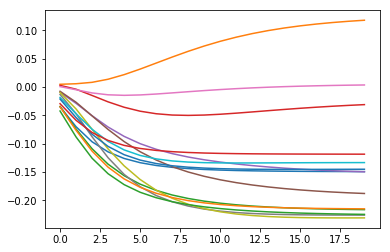

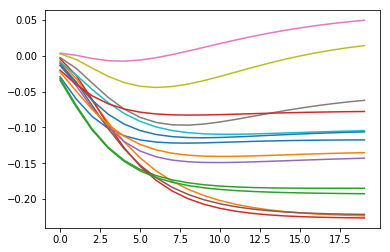

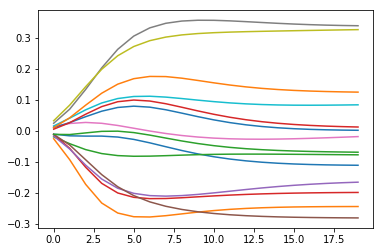

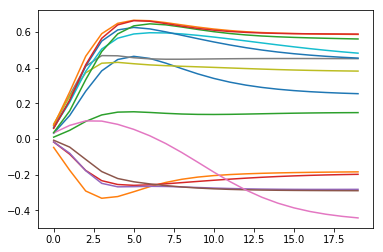

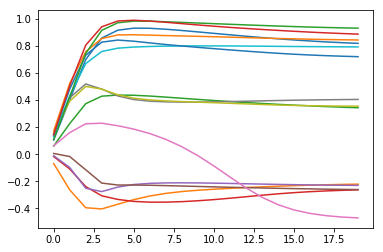

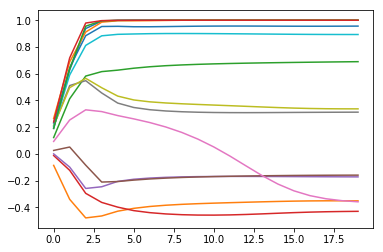

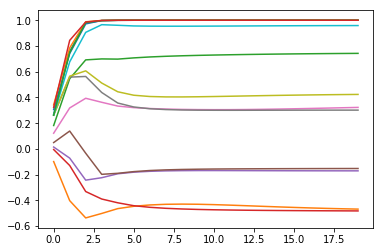

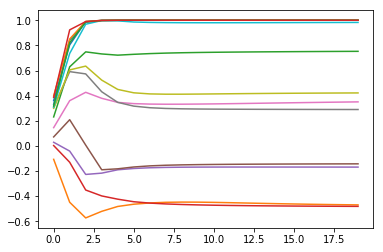

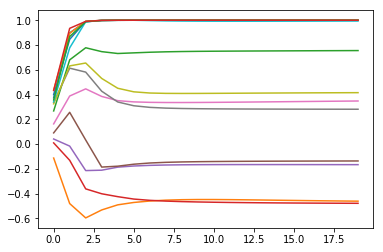

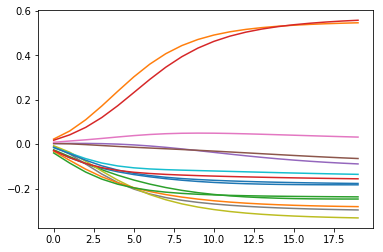

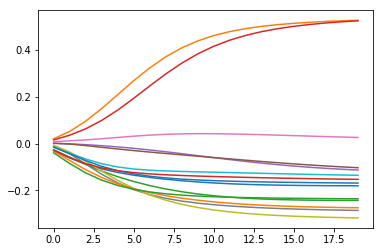

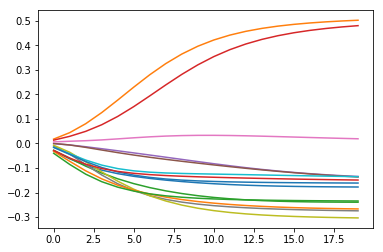

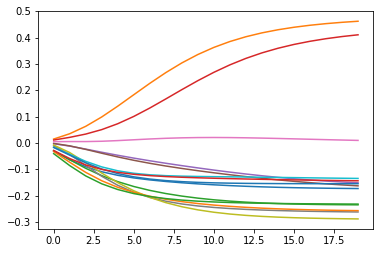

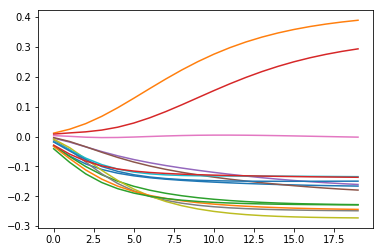

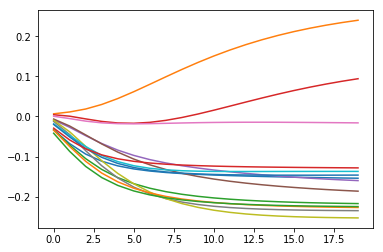

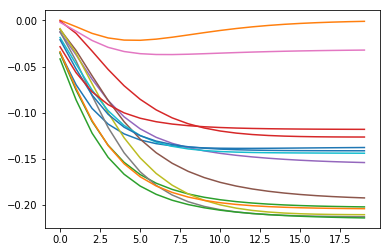

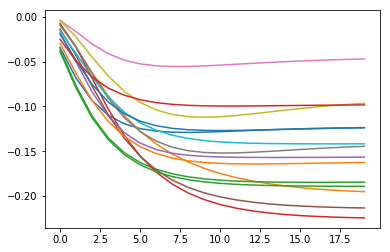

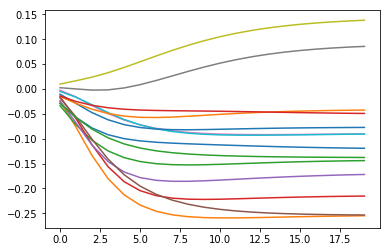

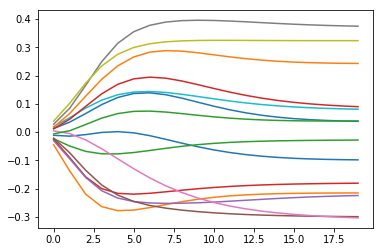

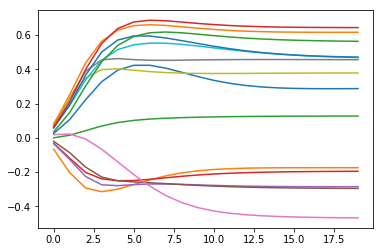

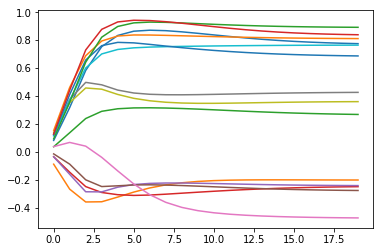

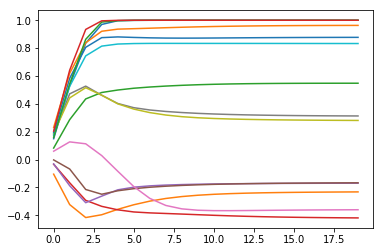

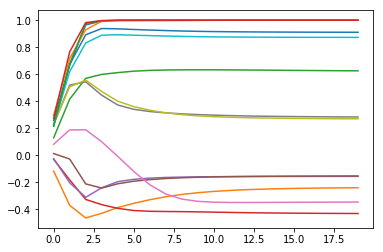

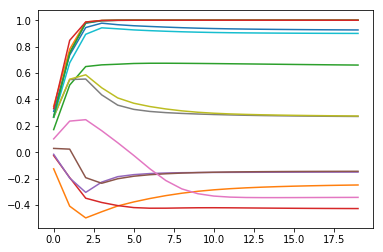

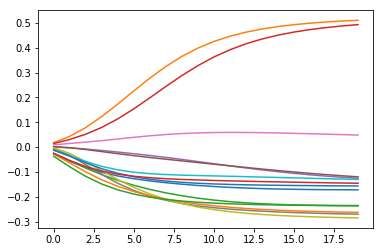

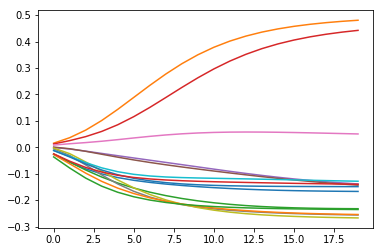

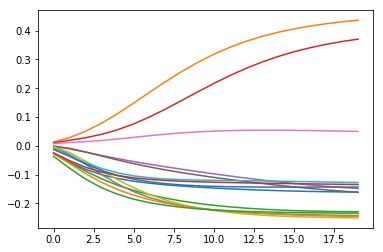

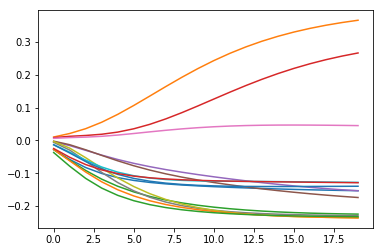

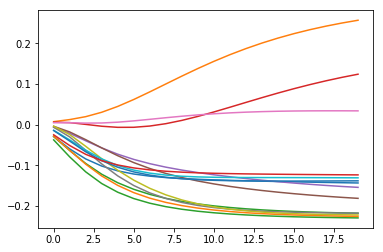

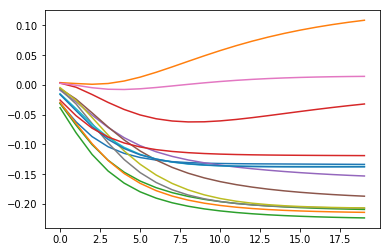

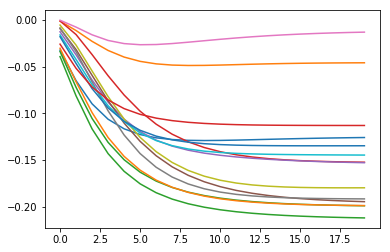

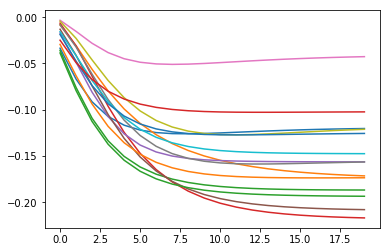

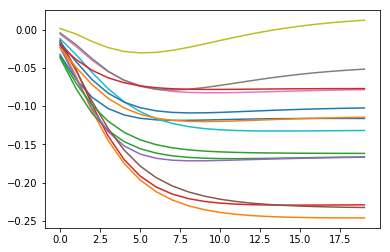

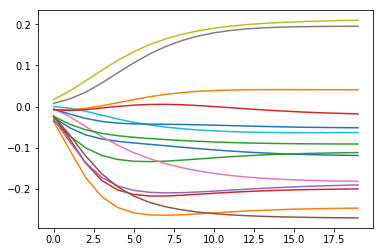

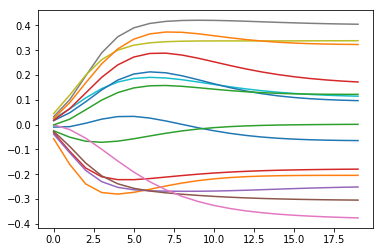

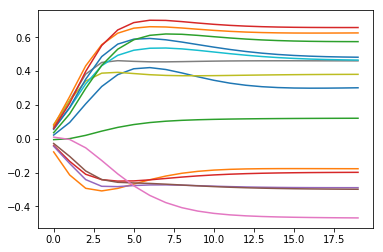

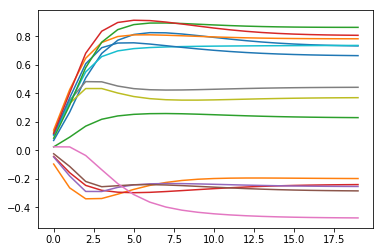

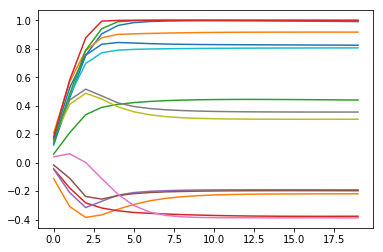

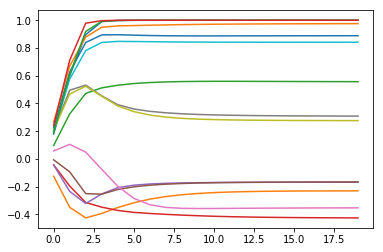

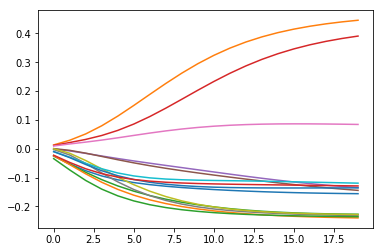

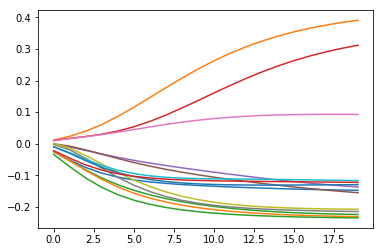

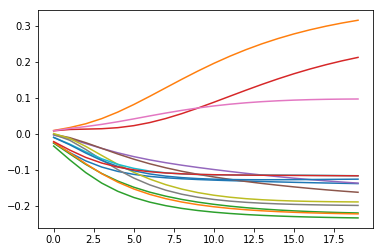

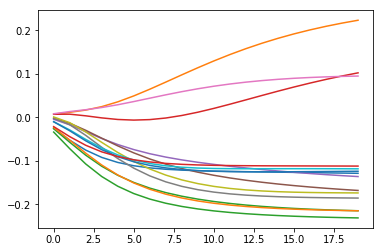

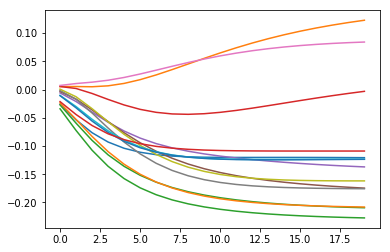

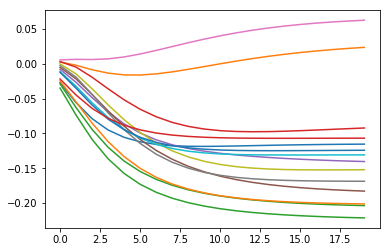

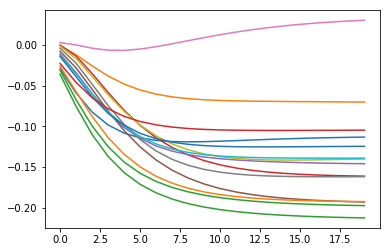

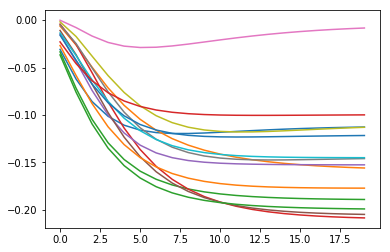

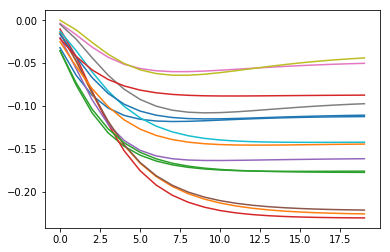

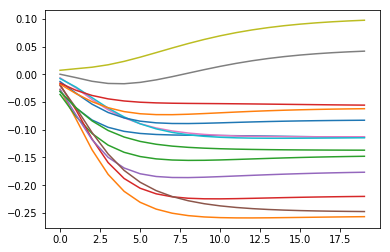

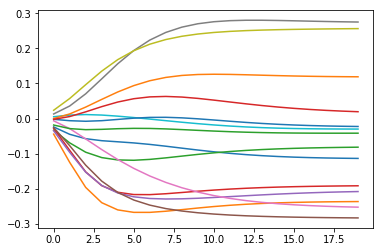

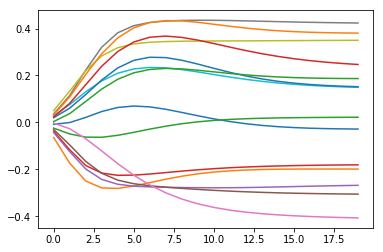

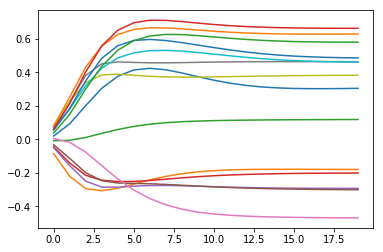

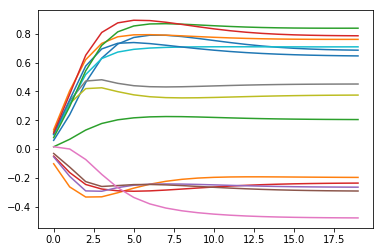

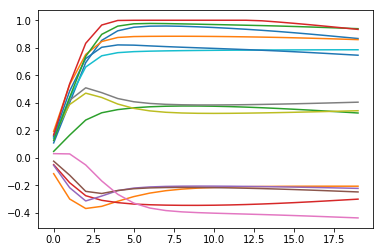

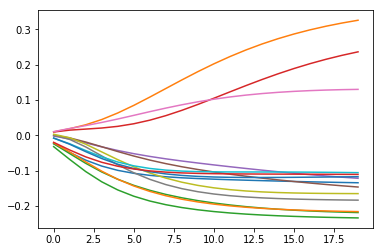

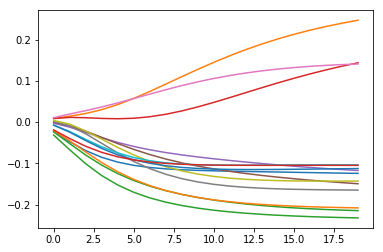

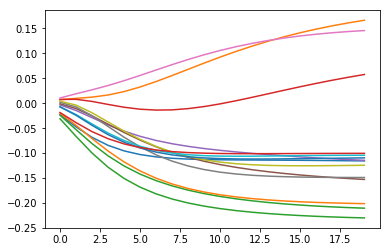

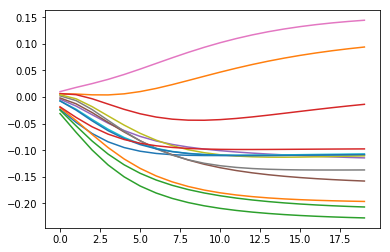

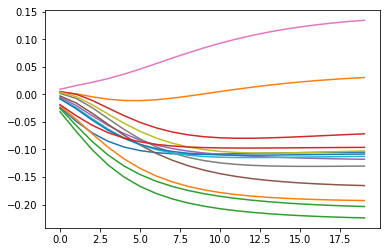

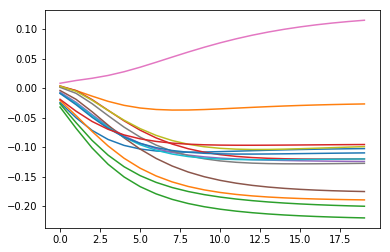

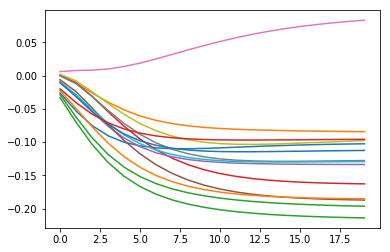

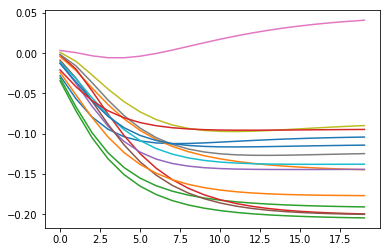

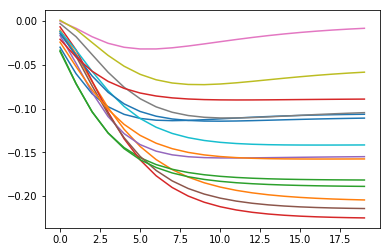

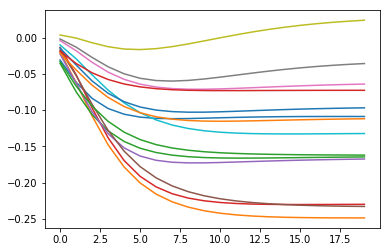

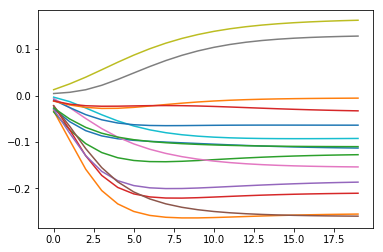

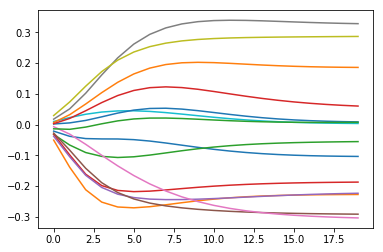

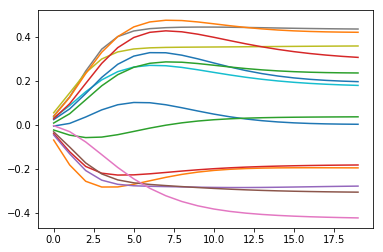

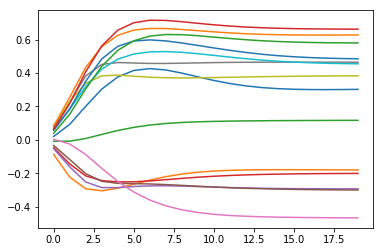

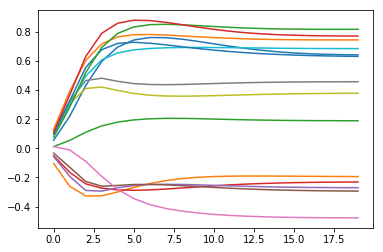

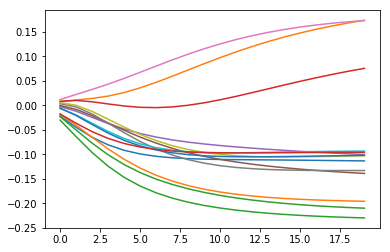

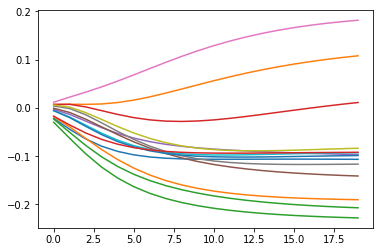

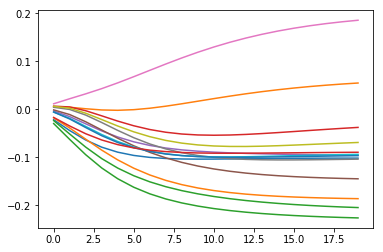

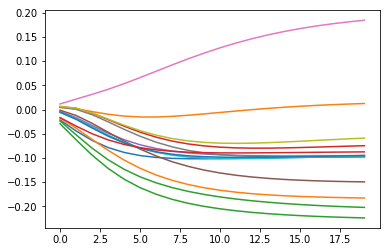

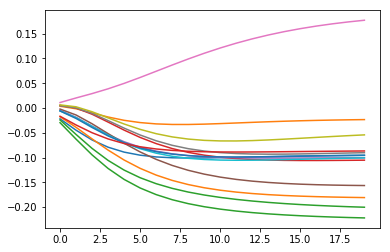

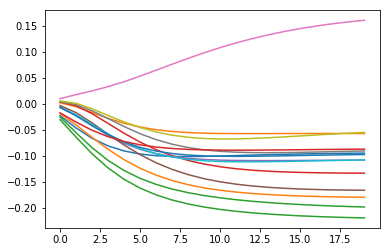

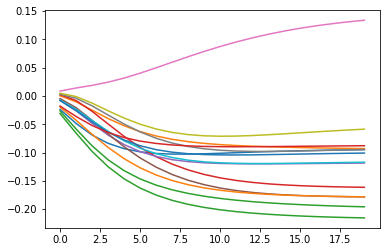

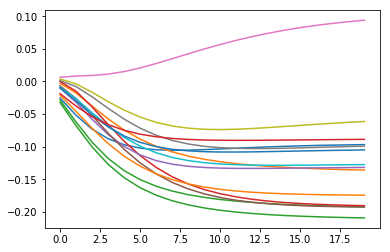

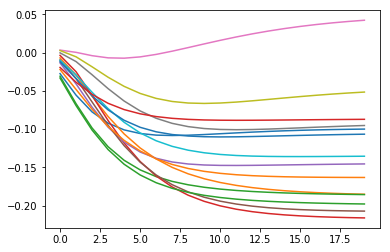

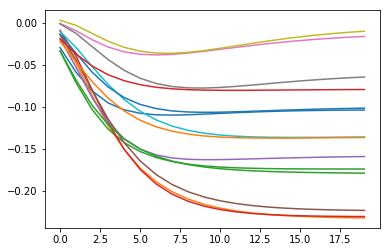

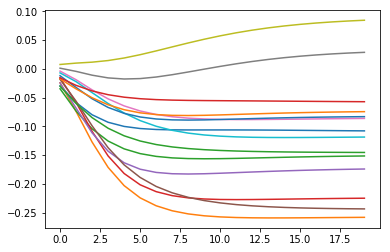

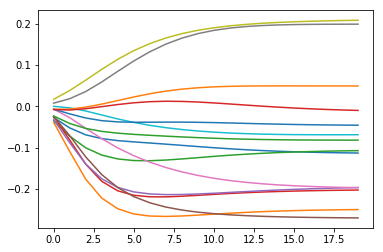

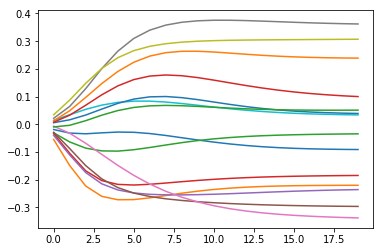

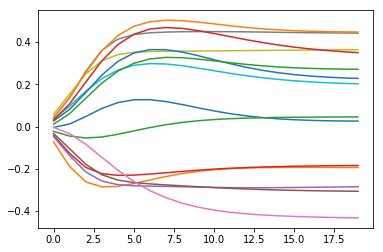

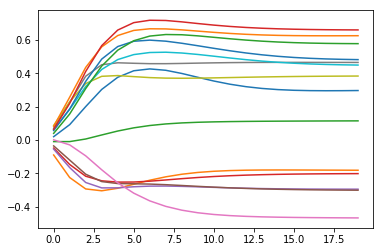

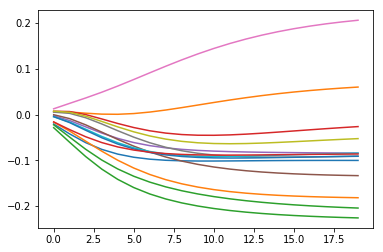

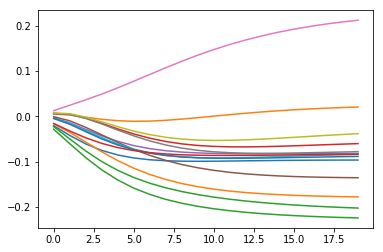

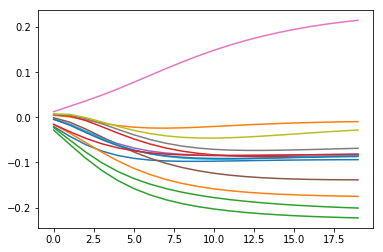

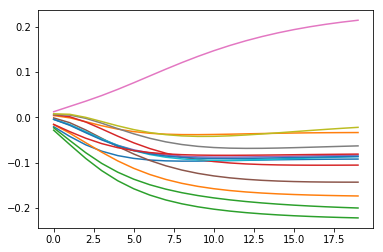

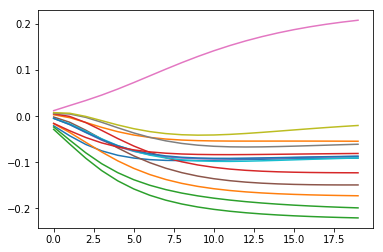

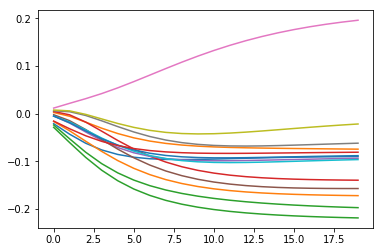

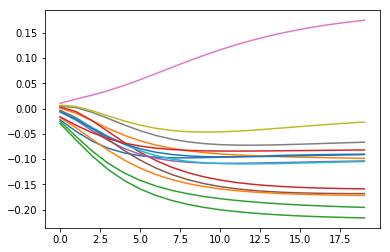

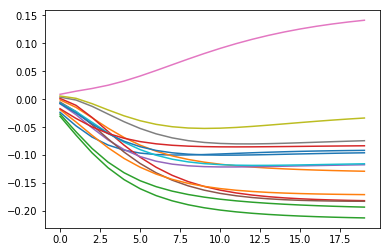

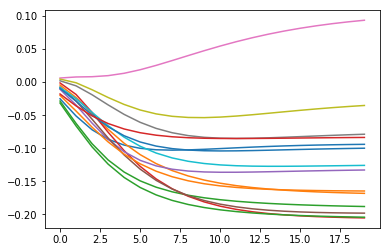

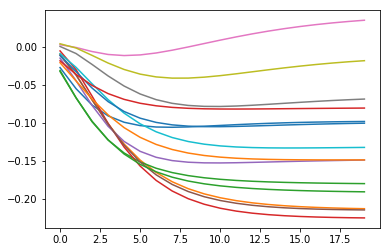

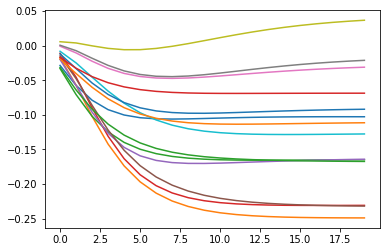

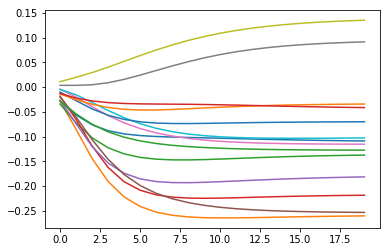

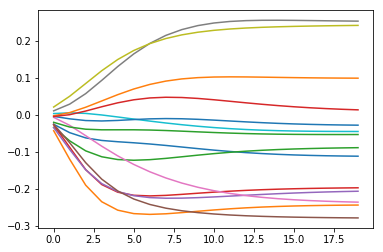

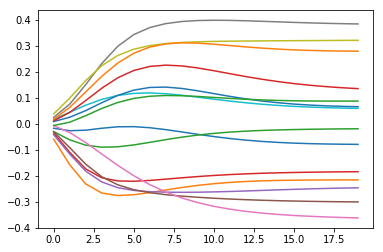

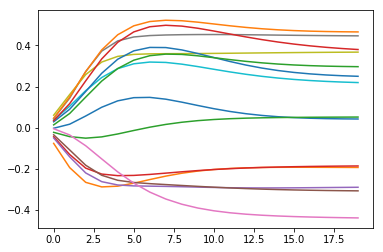

In [29]:
n = 15  # figure with 15x15 digits

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])# * epsilon_std
        ts = sequence_decoder.predict(z_sample)
        plt.figure()
        plt.plot(ts[0,:])